In [6]:
from collections import Counter
import csv
import datetime  # noqa

import pandas as pd
import torch
from torch import nn
import torchtext
import datasets

from torch.utils.data import Dataset, DataLoader

In [22]:
dsets = torchtext.datasets.WikiText2()
NUM_TEXTS = 10_000

In [23]:
ddsets[0].type

ValueError: not enough values to unpack (expected 2, got 1)

In [10]:
>>> for dset, name in zip(dsets, 'train val test'.split()):
>>>     dset = list(dset)[:NUM_TEXTS]
>>>     filepath = DATA_DIR / f'WikiText2-{name}-{len(dset)}.txt'
>>>     with open(filepath, 'wt') as fout:
...         fout.writelines(dset)

In [3]:
from pathlib import Path
DATA_DIR = Path('~').expanduser().absolute() / 'nessvec-data'
DATA_DIR

PosixPath('/home/hobs/nessvec-data')

In [7]:
import re

def tokenize_row(row):
    row['all_tokens'] = [
        tok for tok in re.findall(r"\w+", row['text'].lower()) if tok]
    return row

In [8]:
BATCH_SIZE = 2**12  # 4096
CPU_CORES = 7

In [9]:
WINDOW_WIDTH = 3
EMBED_DIM = 100  # <1> Quite small, just for the tutorial

In [10]:
import pandas as pd
import torchtext

dsets = torchtext.datasets.WikiText2()
num_texts = 10000
filepaths = []

for name, dset in zip('train validation test'.split(), dsets):
    df = pd.DataFrame(dsets[0], columns=['text'])
    df['label'] = 1
    filepaths.append(str(DATA_DIR / f'WikiText2-{name}'))
    with open(filepaths[-1] + f'.{num_texts}.txt', 'wt') as fout:
        fout.writelines(df['text'][:num_texts])

In [11]:
dset = datasets.load_dataset('text', data_files=filepaths[0] + f'.{num_texts}.txt')

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Dataset text downloaded and prepared to /home/hobs/.cache/huggingface/datasets/text/default-e60dda664d838043/0.0.0/08f6fb1dd2dab0a18ea441c359e1d63794ea8cb53e7863e6edf8fc5655e47ec4. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In [12]:
dset = dset.map(tokenize_row)

NameError: name 'tokenize' is not defined

In [33]:
counts = Counter([i for s in dset['train']['all_tokens'] for i in s])
counts = {k: v for k, v in counts.items() if v > 10}  # Filtering
vocab = list(counts.keys())
n_v = len(vocab)
id2tok = dict(enumerate(vocab))
tok2id = {token: id for id, token in id2tok.items()}

In [34]:
def remove_rare_tokens(row):
    row['tokens'] = [t for t in row['all_tokens'] if t in vocab]
    return row

In [35]:
dset = dset.map(remove_rare_tokens)

0ex [00:00, ?ex/s]

In [36]:
def windowizer(row, wsize=WINDOW_WIDTH):
    """ Compute sentence (str) to sliding-window of skip-gram pairs. """
    doc = row['tokens']
    out = []
    for i, wd in enumerate(doc):
        target = tok2id[wd]
        window = [
            i + j for j in range(-wsize, wsize + 1, 1)
            if (i + j >= 0) & (i + j < len(doc)) & (j != 0)
        ]

        out += [(target, tok2id[doc[w]]) for w in window]
    row['moving_window'] = out
    return row

In [37]:
dset = dset.map(windowizer)

0ex [00:00, ?ex/s]

In [38]:
# def neighbor_pairs(tokens, window_width=WINDOW_WIDTH):
#     """ skip-grams: pairs of words that are within window_width of each other

#     >>> neighbor_pairs('We are all one .'.split(), 3)
#     [
#      (We, are),
#      (We, all),
#      (We, one),
#      (are, all),
#     ...
#     """
#     pairs = []
#     for i, wd in enumerate(tokens):
#         target = tok2id[wd]
#         window = [
#             i + j for j in
#             range(-window_width, window_width + 1, 1)
#             if (i + j >= 0)
#             & (i + j < len(tokens))
#             & (j != 0)
#         ]

#         pairs.extend([(target, tok2id[tokens[w]]) for w in window])
#     # huggingface datasets are dictionaries for every text element
#     return pairs

In [39]:
class Word2VecDataset(Dataset):
    """
    Takes a HuggingFace dataset as an input, to be used for a Word2Vec dataloader.
    """

    def __init__(self, dataset, vocab_size, wsize=3):
        self.dataset = dataset
        self.vocab_size = vocab_size
        self.data = [i for s in dataset['moving_window'] for i in s]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [40]:
dataloader = {}
for k in dset.keys():
    dataloader = {
        k: DataLoader(
            Word2VecDataset(
                dset[k],
                vocab_size=n_v),
            batch_size=BATCH_SIZE,
            shuffle=True,
            num_workers=CPU_CORES - 1)
    }

In [41]:
def one_hot_encode(input_id, size):
    vec = torch.zeros(size).float()
    vec[input_id] = 1.0
    return vec

### OHE Example
Example one-hot encoder showing the shapes of the neural network weight matrices and input dataset for a 10-word vocabulary and 3-word sentence.

In [42]:
ohe = one_hot_encode(input_id=3, size=10)
linear_layer = nn.Linear(10, 1, bias=False)

with torch.no_grad():
    linear_layer.weight = torch.nn.Parameter(
        torch.arange(10, dtype=torch.float).reshape(linear_layer.weight.shape))

print(linear_layer.weight)
print(linear_layer(ohe))

Parameter containing:
tensor([[0., 1., 2., 3., 4., 5., 6., 7., 8., 9.]], requires_grad=True)
tensor([3.], grad_fn=<SqueezeBackward3>)


### Instantiate Word2Vec model object

In [43]:
class Word2Vec(nn.Module):
    def __init__(self, vocab_size, embedding_size):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, embedding_size)
        self.expand = nn.Linear(embedding_size, vocab_size, bias=False)

    def forward(self, input):
        # Encode input to lower-dimensional representation
        hidden = self.embed(input)
        # Expand hidden layer to predictions
        logits = self.expand(hidden)
        return logits

In [44]:
model = Word2Vec(n_v, EMBED_SIZE)

# Relevant if you have a GPU:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

# Define training parameters
LR = 5e-4
EPOCHS = 10
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LR)

### Train Word2Vec language model

In [21]:
from tqdm import tqdm  # noqa
running_loss = []

pbar = tqdm(range(EPOCHS * len(dataloader['train'])))
for epoch in range(EPOCHS):
    epoch_loss = 0
    for sample_num, (center, context) in enumerate(dataloader['train']):
        if sample_num % len(dataloader['train']) == 2:
            print(center, context)
            # center: tensor([ 229,    0, 2379,  ...,  402,  553,  521])
            # context: tensor([ 112, 1734,  802,  ...,   28,  852,  363])
        center, context = center.to(device), context.to(device)
        optimizer.zero_grad()
        logits = model(input=context)
        loss = loss_fn(logits, center)
        if not sample_num % 10000:
            # print(center, context)
            pbar.set_description(f'loss[{sample_num}] = {loss.item()}')
        epoch_loss += loss.item()
        loss.backward()
        optimizer.step()
        pbar.update(1)
    epoch_loss /= len(dataloader['train'])
    running_loss.append(epoch_loss)

save_model(model, loss)

loss[0] = 8.67662239074707:   0%|              | 4/5970 [00:00<14:12,  7.00it/s]

tensor([2123,   94,   13,  ...,  140,  364, 1206]) tensor([ 229, 1914, 1012,  ...,   14,  120,  253])


loss[0] = 7.107980251312256:  10%|█          | 600/5970 [01:10<14:31,  6.16it/s]

tensor([2087,   13,    5,  ..., 1593,   56, 3870]) tensor([  32,    8, 2687,  ..., 4708,  428,  132])


loss[0] = 6.509765625:  20%|███▏            | 1197/5970 [02:17<13:42,  5.80it/s]

tensor([ 517, 1643,  387,  ...,   94,   23,   13]) tensor([ 276, 3764,  261,  ...,    8,    9,  272])


loss[0] = 6.41121768951416:  30%|███▎       | 1794/5970 [03:25<12:54,  5.39it/s]

tensor([1862,  326, 2572,  ...,  245,   14,  386]) tensor([ 26,   5,  18,  ...,   8,  18, 387])


loss[0] = 6.308187961578369:  40%|████      | 2391/5970 [04:34<10:11,  5.85it/s]

tensor([4084,  226, 1760,  ..., 1755, 1761,   14]) tensor([   8,    9, 1778,  ...,    8, 1392,    9])


loss[0] = 6.311797142028809:  50%|█████     | 2988/5970 [05:45<09:08,  5.43it/s]

tensor([   9,  253,   17,  ..., 1351,    9, 2916]) tensor([  25,   32,   32,  ...,  495, 2365,   26])


loss[0] = 6.2237114906311035:  60%|█████▍   | 3585/5970 [06:54<06:52,  5.78it/s]

tensor([  41, 3101, 4526,  ...,    8, 2542,  244]) tensor([1761,    9,    8,  ..., 1716,   13,  389])


loss[0] = 6.250300884246826:  70%|███████   | 4182/5970 [08:04<05:11,  5.75it/s]

tensor([1512,   26,  372,  ...,    9, 2118,   35]) tensor([ 253,  102,  229,  ..., 4745,  116, 1879])


loss[0] = 6.29862117767334:  80%|████████▊  | 4779/5970 [09:13<03:25,  5.79it/s]

tensor([  91, 4574,    9,  ...,  418,  269,  223]) tensor([2561,  223,    8,  ..., 1084,   25,    9])


loss[0] = 6.220264911651611:  90%|█████████ | 5376/5970 [10:24<01:48,  5.47it/s]

tensor([  26,  120, 3233,  ...,   32, 1635,  112]) tensor([1078, 2409,    9,  ...,  983,   18, 4087])


loss[0] = 6.220264911651611: 100%|█████████▉| 5969/5970 [11:33<00:00,  8.25it/s]

NameError: name 'save_model' is not defined

In [59]:
def save_model(model, loss=torch.tensor(float("NaN")), name='Word2Vec', model_dir=Path(DATA_DIR) / 'models'):
    """ Save the model with a unique timestamped filename including shape and loss """
    try:
        loss = loss.item()
    except AttributeError:
        pass
    model_dir.mkdir(exist_ok=True)

    num_embeddings, embedding_dim = model.state_dict()["embed.weight"].shape
    now = datetime.datetime.now()

    # filename = f'Word2Vec-state_dict-{now.isoformat()[:13]}.pt'
    # filename = f'Word2Vec-state_dict-{num_embeddings}x{embedding_dim}+{embedding_dim}x{num_embeddings}.pt'
    filename = f'{name}-state_dict-{num_embeddings}x{embedding_dim}-{now.isoformat()[:13]}-loss_{loss}.pt'

    torch.save(model.state_dict(), model_dir / filename)
    return model_dir / filename

In [60]:
save_model(model, loss)

4943x100


PosixPath('/home/hobs/nessvec-data/models/Word2Vec-state_dict-4943x100-2022-02-22T22-loss_6.232699871063232.pt')

In [55]:
model.state_dict()["expand.weight"].shape

torch.Size([4943, 100])

### Learning curve

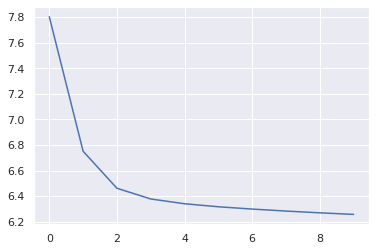

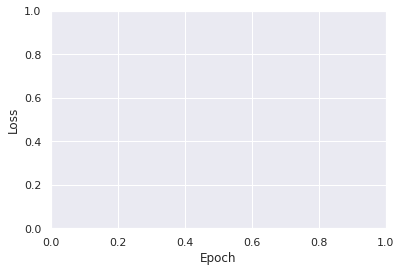

In [61]:
import seaborn as sns  # noqa
import matplotlib.pyplot as plt  # noqa
sns.set_theme()
plt.plot(running_loss)
plt.show(block=False)

sns.set_theme()
# sns.set_style('whitegrid')
# learning curve
plt.grid('on')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show(block=False)

In [64]:
###################################################
# Evaluation (word semantic similarity)

###################################################
# Vectors = embedding layer model weights

wordvecs = model.expand.weight.cpu().detach().numpy()
tokens = ['father', 'mother', 'writer', 'woman', 'man', 'black', 'japanese', 'men', 'women', 'people', 'person']

# Vectors = embedding layer model weights
###################################################



from scipy.spatial import distance  # noqa
import numpy as np  # noqa


def get_distance_matrix(wordvecs, metric):
    dist_matrix = distance.squareform(distance.pdist(wordvecs, metric))
    return dist_matrix


def get_k_similar_words(word, dist_matrix, k=10):
    idx = tok2id[word]
    dists = dist_matrix[idx]
    ind = np.argpartition(dists, k)[:k + 1]
    ind = ind[np.argsort(dists[ind])][1:]
    out = [(i, id2tok[i], dists[i]) for i in ind]
    return out


dmat = get_distance_matrix(wordvecs, 'cosine')
for word in tokens:
    print(word, [t[1] for t in get_k_similar_words(word, dmat)], "\n")

father ['mother', 'own', 'name', 'book', 'him', 'career', 'family', 'john', 'life', 'role'] 

mother ['brother', 'father', 'parents', 'wife', 'personal', 'jack', 'brothers', 'children', 'name', 'friend'] 

writer ['james', 'self', 'executive', 'wheeler', 'making', 'album', 'studio', 'entertainment', 'nesbitt', 'cover'] 

woman ['me', 'care', 'looking', 'love', 'serious', 'got', 'tell', 'makes', 'want', 'know'] 

man ['who', 'bass', 'as', 'an', 'is', 'he', 'however', 'was', 'long', 'she'] 

black ['is', 'be', 'not', 'white', 'that', 'are', 'often', 'also', 'it', 'this'] 

japanese ['contest', 'spear', 'portion', 'mayor', 'chutzpah', 'table', 'crescent', 'frederick', 'orozco', 'complicated'] 

men ['were', 'other', 'are', 'their', 'two', 'some', 'more', 'people', 'of', 'and'] 

women ['show', 'league', 'team', 'football', 'underground', 'national', 'men', 'teams', 'best', 'television'] 

people ['about', 'more', 'some', 'are', 'have', 'or', 'all', 'were', 'they', 'to'] 

person ['process

In [1]:
tok2id.items(10)


NameError: name 'tok2id' is not defined